In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
import MAPInference as mapi
from matplotlib import pyplot as plt
import pickle
import os
from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg
from sklearn.linear_model import LinearRegression as lreg
from sklearn.decomposition import PCA as pca
from scipy.optimize import minimize

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
# df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [3]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']

In [4]:
getf = lambda s : s*2.5 + (1-s)*3.5
gettheta = lambda s: (s*60. + (1-s)*10.)*np.pi/180
xfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)-np.sin(gettheta(s)+np.pi/4.))) 
yfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)+np.sin(gettheta(s)+np.pi/4.))) 
ang = lambda x,y: np.arctan(x/y)*180/np.pi

wallmorphx = lambda s: 1.2*(xfreq(s)-xfreq(-.1))/(xfreq(1.1)-xfreq(-.1))-.1
wallmorphy = lambda s: 1.2*(yfreq(s)-yfreq(-.1))/(yfreq(1.1)-yfreq(-.1))-.1

def trial_info_to_stim(trial_info):
    wall = trial_info['morphs']+trial_info['wallJitter']
    bckgnd = trial_info['morphs']+trial_info['bckgndJitter']
    tower = np.minimum(np.maximum(trial_info['morphs']+trial_info['towerJitter'],0),1)

    return np.concatenate((xfreq(wall)[:,np.newaxis],wall[:,np.newaxis],bckgnd[:,np.newaxis],tower[:,np.newaxis]),axis=1)

def trial_info_to_morph(trial_info):
    wall = trial_info['morphs']+trial_info['wallJitter']
    bckgnd = trial_info['morphs']+trial_info['bckgndJitter']
    tower = np.minimum(np.maximum(trial_info['morphs']+trial_info['towerJitter'],0),1)

    return np.concatenate((wallmorphx(wall)[:,np.newaxis],wallmorphy(wall)[:,np.newaxis],bckgnd[:,np.newaxis],tower[:,np.newaxis]),axis=1)
    
def single_session_data(sess):
#     print(sess)
    VRDat = pp.behavior_dataframe(sess["data file"])
    trial_info, tstarts_, teleports_ = u.by_trial_info(VRDat)
#     return trial_info_to_stim(trial_info)
    return trial_info_to_morph(trial_info)

def single_mouse_data(mouse,df_mouse):
#     df_mouse = df[df["MouseName"]==mouse]
    data = {}
    for i in range(df_mouse.shape[0]):
        sess = df_mouse.iloc[i]
        date, num = sess['DateFolder'],sess['SessionNumber']
        key = date + str(num) 
        
        data[key] = single_session_data(sess)
        
    return data

def single_mouse_em_all(mouse,data = None):
    if data is None:
        data = single_mouse_data(mouse,df[df["MouseName"]==mouse])
    else:
        pass
    
    for i, (key,arr) in enumerate(data.items()):
        if i == 0:
            em_all = arr
        else:
            em_all = np.concatenate((em_all,arr),axis=0)
    return em_all

def gaussian(mu,sigma,x):
    '''radial basis function centered at 'mu' with width 'sigma', sampled at 'x' '''
    return np.exp(-(mu-x)**2/sigma**2)


In [5]:
#load FFT KNN model
with open("D:\\Morph_Results\\FrameGrabber_FFT_KNNReg_model.pkl",'rb') as f:
    knn_model = pickle.load(f)
print(knn_model.keys())

dict_keys(['model', 'train_morphs', 'stimkeys', 'eig_vec'])


# show stimulus is essentially 1D

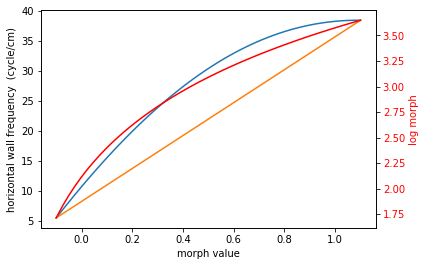

In [6]:
m = np.linspace(-.1,1.1)
f,ax = plt.subplots()
ax.plot(m,xfreq(m))
ax.plot(m,np.linspace(xfreq(-.1),xfreq(1.1)))
ax.set_xlabel('morph value')
ax.set_ylabel('horizontal wall frequency  (cycle/cm)')

ax2= ax.twinx()
ax2.plot(m,np.log(np.linspace(xfreq(-.1),xfreq(1.1))),color='red')
ax2.set_ylabel('log morph',color='red')
ax2.tick_params(axis='y',labelcolor='red')

# ax.legend(('actual','morph'))
# ax2.legend('log(morph)')
f.savefig("D:\\Morph_Results\\figures\\wallmorph.png",format="png")


In [7]:
print(ang(xfreq(1.1),yfreq(1.1)), ang(xfreq(-.1),yfreq(-.1)))

65.0 4.999999999999997


In [35]:
for m, mouse in enumerate(mice):
    
    print(mouse)
    if m ==0:
        EM_all = single_mouse_em_all(mouse)
    else:
        EM_all = np.concatenate((EM_all,single_mouse_em_all(mouse)),axis=0)
    
        



4139265.3


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4139265.4
4139265.5
4222168.1
deleting last index from trial start
deleting last index from trial start
4343703.1
4343706
4222153.1
4222153.2
4222153.3
4222174.1
4222154.1
4343702.1


[[-0.57038834 -0.47796743 -0.47704516 -0.46758121]
 [-0.80659747  0.20170983  0.46650341  0.30180826]
 [-0.15165299  0.79326425 -0.58916754 -0.02479536]
 [ 0.03254264  0.31873519  0.45572369 -0.83046058]]


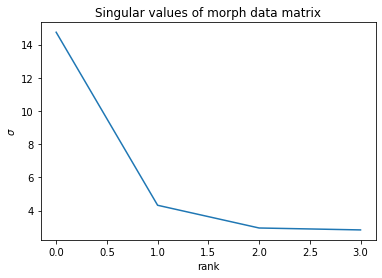

In [43]:
u_,s_,vh_ = np.linalg.svd(EM_all[:,:],full_matrices=False)
f,ax = plt.subplots()
ax.plot(s_**.5)
ax.set_xlabel("rank")
ax.set_ylabel("$\sigma$")
ax.set_title("Singular values of morph data matrix")
f.savefig("D:\\Morph_Results\\stim_singularvalues.png",format="png")
print(vh_)
# vh_norm = -1*vh_
vh_norm = vh_/vh_.sum(axis=1,keepdims=True)

# Make cumulative prior for each session for each mouse

In [8]:
x=np.linspace(-.1,1.1,num=1000)

def cumulative_prior(mouse,df,first_ind=5,sigma=.1,x=np.linspace(-.3,1.3,num=1000)):
    behav_sessions = df[df["MouseName"]==mouse]
    imag_sessions = behav_sessions[behav_sessions['Imaging']==1]
    morph_data = single_mouse_data(mouse,behav_sessions)
    
    PRIORS = []
    for ind in range(first_ind,imag_sessions.shape[0]):
        sess = imag_sessions.iloc[ind]


        # calculate cumulative prior up to current session
        date_folder,sessn = None,-np.inf
        em_all = None
        b_ind = 0
        while date_folder!=sess['DateFolder'] or sessn<sess["SessionNumber"]:
            b_sess = behav_sessions.iloc[b_ind]
            date_folder = b_sess['DateFolder']
            sessn = b_sess['SessionNumber']
            if em_all is None:
                em_all = morph_data[date_folder+str(sessn)]
            else:
                em_all = np.concatenate((em_all,morph_data[date_folder+str(sessn)]),axis=0)
            b_ind+=1

#         feats = np.zeros()
        em_1d = knn_model['model'].predict(em_all)
        print(em_1d.shape)
        
        prior = np.mean(gaussian(em_1d[:,np.newaxis],sigma,x[np.newaxis,:]),axis=0)
        
        PRIORS.append(prior)
        
        
    return PRIORS


    

In [26]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']
rare_mice,freq_mice = mice[:5],mice[5:]
# for mouse in rare_mice:
#     print(mouse)
#     cumulative_prior(mouse,df)

# rare_priors = {mouse:cumulative_prior(mouse,df) for mouse in rare_mice}
# freq_priors = {mouse:cumulative_prior(mouse,df,first_ind=4) for mouse in freq_mice}

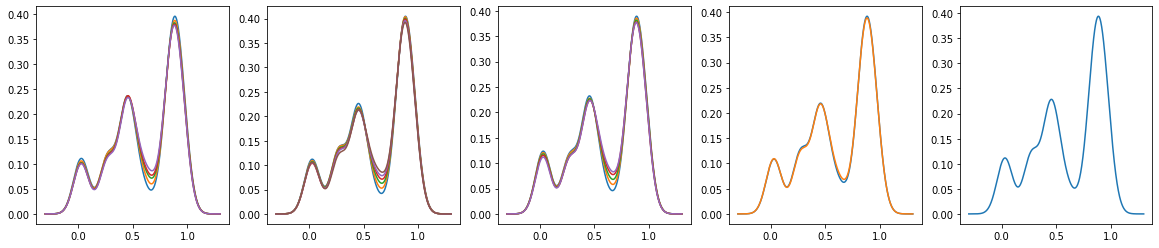

In [11]:
f,ax = plt.subplots(1,len(rare_mice),figsize=[20,4])
for i, (mouse,priors) in enumerate(rare_priors.items()):
    for prior in priors:
        ax[i].plot(x,prior)

# f,ax = plt.subplots(1,len(freq_mice),figsize=[20,4])
# for i, (mouse,priors) in enumerate(freq_priors.items()):
#     for prior in priors:
#         ax[i].plot(x,prior)

In [9]:
em_all = single_mouse_em_all('4139265.5')

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


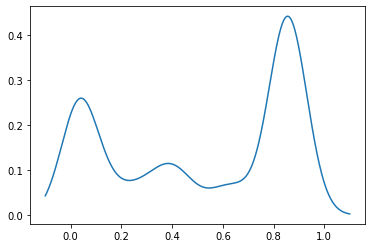

In [16]:
em_1d = knn_model['model'].predict(em_all)
# em_1d = (em_1d-np.amin(em_1d))/(np.amax(em_1d)-np.amin(em_1d))
prior = np.mean(gaussian(em_1d[:,np.newaxis],.1,x[np.newaxis,:]),axis=0)
f,ax = plt.subplots()
ax.plot(x,prior)

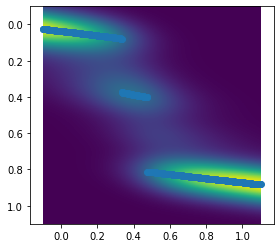

In [22]:
post = prior*gaussian(x[:,np.newaxis],.3,x[np.newaxis,:])
post = post/post.sum(axis=1,keepdims=True)
map_ = x[np.argmax(post,axis=1)]
f,ax = plt.subplots()
ax.imshow(post.T,extent=[-.1,1.1,1.1,-.1])
ax.scatter(x,map_)

# look at a few example sessions

In [63]:
def single_mouse_sf_regression(mouse,df,first_ind=5,sigma_prior=.1,sigma_likelihood=.1,
                              x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:],mus = np.linspace(-.3,1.3,num=1000)[:,np.newaxis],
                              plot=False):
    behav_sessions = df[df["MouseName"]==mouse]
    imag_sessions = behav_sessions[behav_sessions["Imaging"]==1]
    morph_data = single_mouse_data(mouse,behav_sessions)
    
    WALLMORPH, YTARGET, YHAT, PRIORS, SF,SFHAT = [],[],[],[],[],[]
    
    for ind in range(first_ind,imag_sessions.shape[0]):
        sess = imag_sessions.iloc[ind]
        
        print(ind)
        # calculate cumulative prior up to current session
        date_folder,sessn = None,-np.inf
        em_all = None
        b_ind = 0
        while date_folder!=sess['DateFolder'] or sessn<sess["SessionNumber"]:
            b_sess = behav_sessions.iloc[b_ind]
            date_folder = b_sess['DateFolder']
            sessn = b_sess['SessionNumber']
            if em_all is None:
                em_all = morph_data[date_folder+str(sessn)]
            else:
                em_all = np.concatenate((em_all,morph_data[date_folder+str(sessn)]),axis=0)
            b_ind+=1


#         em_1d = knn_model['model'].predict(em_all)[:,np.newaxis]
        em_1d = em_all[:,:1]
        prior = np.mean(gaussian(em_1d,sigma_prior,x),axis=0,keepdims=True)
        PRIORS.append(prior)
        prior_spl = lambda x: np.mean(gaussian(em_1d,sigma_prior,x),axis=0,keepdims=True)



        # load data
        with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
        VRDat,S = data['VRDat'],data['S']
        S[np.isnan(S)]=0
        S = S/np.percentile(S,95,axis=0)
        trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
        S_trial_mat[np.isnan(S_trial_mat)]=0


        # similarity fraction
        sf = u.similarity_fraction(S_trial_mat,trial_info)
        SF.append(sf)

        morphmat = trial_info_to_morph(data['trial_info'])
        wallMorph = morphmat[:,0]
#         wallMorph =knn_model['model'].predict(morphmat)
        WALLMORPH.append(wallMorph)
    
#         hist,edges = np.histogram(wallMorph, bins=np.linspace(-.1,1.11,num=10))
#         weight = np.amax(hist)-hist
#         weight = weight/weight.sum()
#         wallbins = np.digitize(wallMorph,edges[1:])
#         weights = weight[wallbins]

         # need to add cross val
        ytarget = x[0,np.argmax(prior_spl(x)*gaussian(wallMorph[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
        yhat,sfhat = np.zeros(ytarget.shape),np.zeros(ytarget.shape)
        for trial in range(yhat.shape[0]):
            train = np.ones(yhat.shape)>0
            train[trial]= False
            linmodel = hreg().fit(sf[train,np.newaxis],ytarget[train].ravel())
            yhat[trial]=linmodel.predict(sf[trial].reshape(-1,1))
            
            linmodel = hreg().fit(ytarget[train,np.newaxis],sf[train].ravel())
            sfhat[trial] = linmodel.predict(ytarget[trial].reshape(-1,1))

        YHAT.append(yhat)
        SFHAT.append(sfhat)
    #     linmodel = hreg().fit(sf[:,np.newaxis],ytarget[:,np.newaxis])
       
        
    return {'wallmorph':WALLMORPH, 'ytarget':YTARGET,'yhat': YHAT, 'priors':PRIORS,'sf': SF,'sfhat':SFHAT}

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9


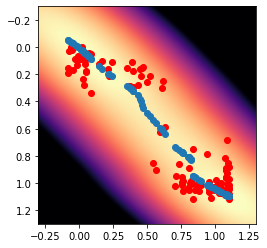

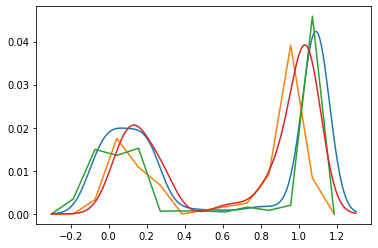

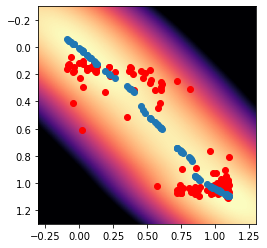

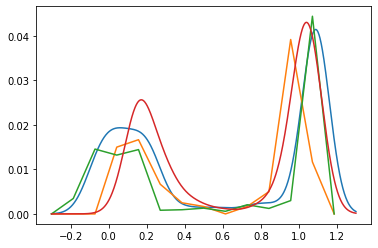

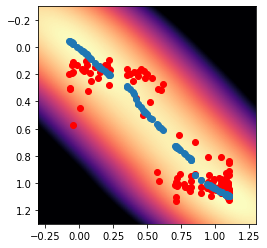

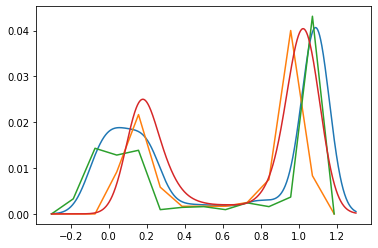

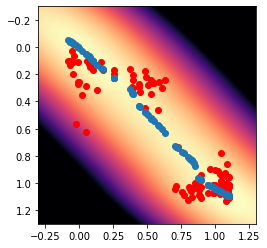

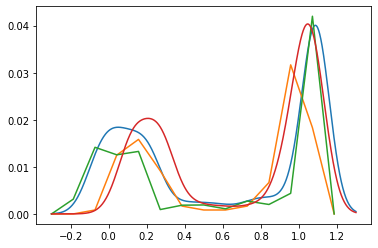

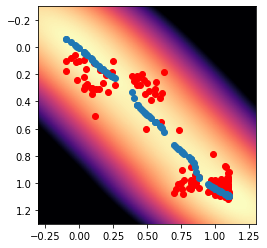

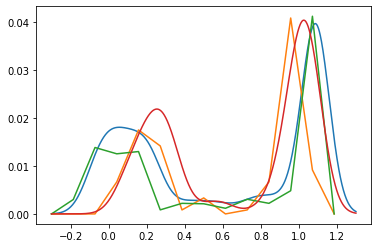

In [34]:
res = single_mouse_sf_regression('4139265.5',df,plot=True)

In [64]:
# single_mouse_sf_regression('4139265.5',df,first_ind=5)
rare_sfreg = {mouse:single_mouse_sf_regression(mouse,df) for mouse in rare_mice}
freq_sfreg = {mouse:single_mouse_sf_regression(mouse,df,first_ind=4) for mouse in freq_mice}

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9
10


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


deleting last index from trial start
deleting last index from trial start
5
6


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6
7


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6
7
8


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6
7
8


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6


In [65]:
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'wb') as f:
    pickle.dump(rare_sfreg,f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'wb') as f:
    pickle.dump(freq_sfreg,f)

In [66]:
def mean_prior_post(dict_sfreg,sigma_likelihood=.3,x=np.linspace(-.3,1.3,num=1000)[np.newaxis,:]):
    mice = [mouse for mouse in dict_sfreg.keys()]
    priors = np.zeros([len(mice),x.shape[1]])
    for i, (mouse,res) in enumerate(dict_sfreg.items()):
        _prior=None
        for _p in res['priors']:
            if _prior is None:
                _prior = _p
            else:
                _prior+=_p
        _prior = _prior/_prior.sum()
        priors[i,:]=_prior
        
    prior = _prior.mean(axis=0,keepdims=True)
    prior = prior/prior.sum()
    post = prior*gaussian(np.linspace(-.11,1.11,num=1000)[:,np.newaxis],sigma_likelihood,np.linspace(-.3,1.3,num=1000)[np.newaxis,:])
    post = post/post.sum(axis=1)
    return priors, prior, post

In [67]:
rare_priors,rare_prior,rare_post = mean_prior_post(rare_sfreg)
freq_priors,freq_prior,freq_post = mean_prior_post(freq_sfreg)


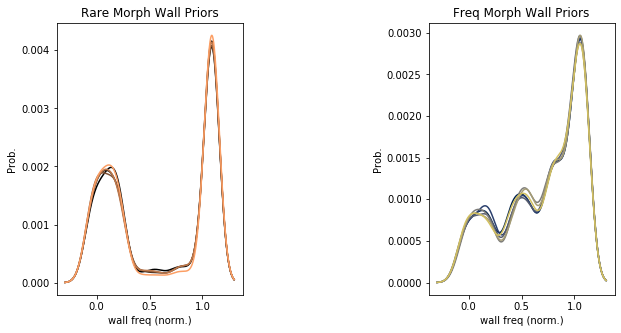

In [68]:
x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:]
f,ax = plt.subplots(1,2,figsize=[10,5])
for row in range(rare_priors.shape[0]):
    ax[0].plot(x.ravel(),rare_priors[row,:].ravel(),color=plt.cm.copper(np.float(row)/np.float(len(rare_mice))))

for row in range(freq_priors.shape[0]):
    ax[1].plot(x.ravel(),freq_priors[row,:].ravel(),color=plt.cm.cividis(np.float(row)/np.float(len(freq_mice))))


# ax[0].plot(x.ravel(),rare_prior.ravel(),color='brown',linewidth=5)
ax[0].set_xlabel('wall freq (norm.)')
ax[0].set_ylabel('Prob.')
ax[0].set_title('Rare Morph Wall Priors')
# ax[1].plot(x.ravel(),freq_prior.ravel(),color='blue',linewidth=5)
ax[1].set_xlabel('wall freq (norm.)')
ax[1].set_ylabel('Prob.')
ax[1].set_title('Freq Morph Wall Priors')
f.subplots_adjust(wspace=1)
f.savefig("D:\\Morph_Results\\priors.png",format="png")

Text(0.5, 1.0, 'Marginal Histograms vs Ideal Freq. Prior')

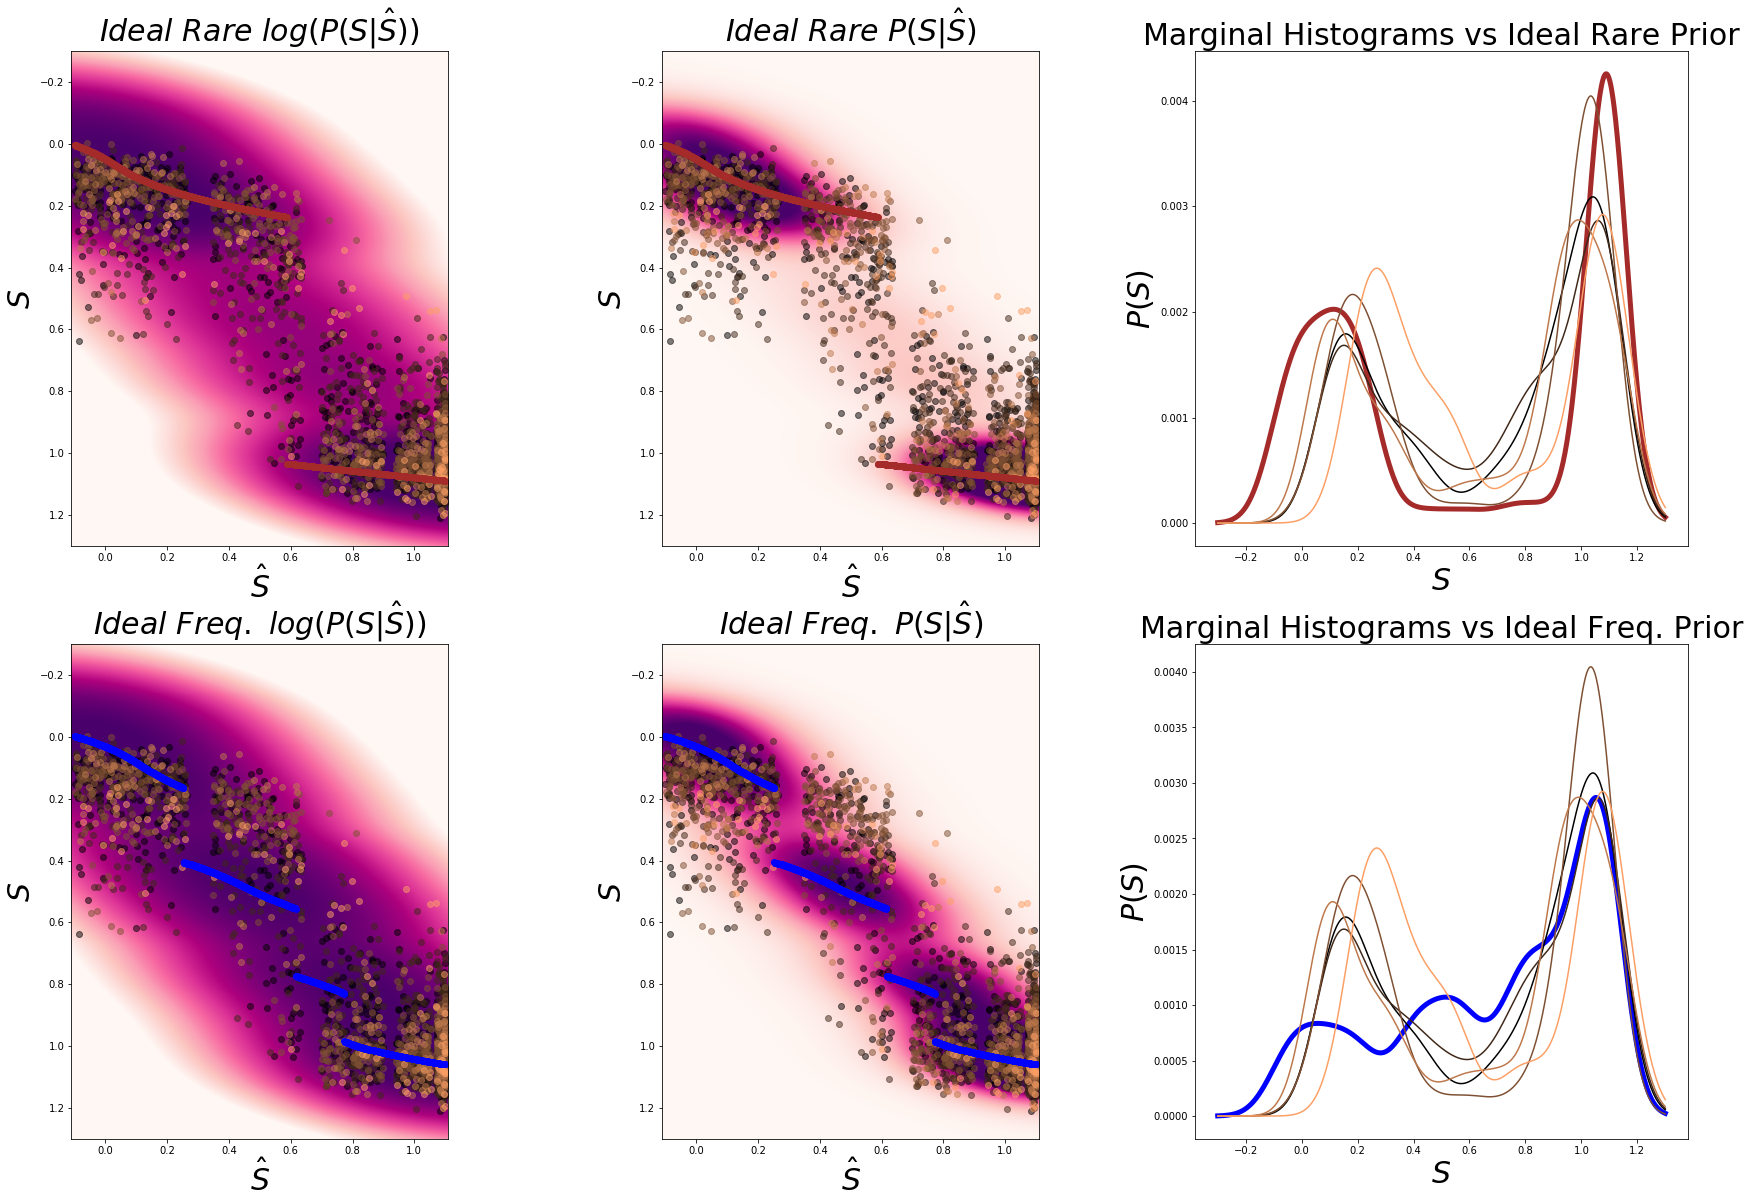

In [69]:
sigma_likelihood=.3
x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:]
f,ax = plt.subplots(2,3,figsize=[30,20])

rare_logpost = np.log(rare_post.T)
ax[0,0].imshow(rare_logpost,vmin=np.percentile(rare_logpost,20),vmax=np.percentile(rare_logpost,95),extent =[-.11,1.11,1.3,-.3],cmap='RdPu')
ax[0,1].imshow(rare_post.T,vmin=np.percentile(rare_post,5),vmax=np.percentile(rare_post,95),extent =[-.11,1.11,1.3,-.3],cmap='RdPu')
ax[0,2].plot(x.ravel(),rare_prior.ravel(),color='brown',linewidth=5)

freq_logpost = np.log(freq_post.T)
ax[1,0].imshow(freq_logpost,vmin=np.percentile(freq_logpost,20),vmax=np.percentile(freq_logpost,95),extent =[-.11,1.11,1.3,-.3],cmap='RdPu')
ax[1,1].imshow(freq_post.T,vmin=np.percentile(freq_post,5),vmax=np.percentile(freq_post,95),extent =[-.11,1.11,1.3,-.3],cmap='RdPu')
ax[1,2].plot(x.ravel(),freq_prior.ravel(),color='blue',linewidth=5)

for i, (mouse, res) in enumerate(rare_sfreg.items()):
    _wallmorph = np.concatenate(res['wallmorph'])
    _yhat = np.concatenate(res['yhat'])
    ax[0,0].scatter(_wallmorph,_yhat,color=plt.cm.copper(np.float(i/len(rare_mice))),alpha=.5)
    ax[0,1].scatter(_wallmorph,_yhat,color=plt.cm.copper(np.float(i/len(rare_mice))),alpha=.5)
    ax[1,0].scatter(_wallmorph,_yhat,color=plt.cm.copper(np.float(i/len(rare_mice))),alpha=.5)
    ax[1,1].scatter(_wallmorph,_yhat,color=plt.cm.copper(np.float(i/len(rare_mice))),alpha=.5)
    
    sfsmooth = np.mean(gaussian(_yhat[:,np.newaxis],.1,x),axis=0)
    ax[0,2].plot(x.ravel(),sfsmooth/sfsmooth.sum(),color=plt.cm.copper(np.float(i/len(rare_mice))))
    ax[1,2].plot(x.ravel(),sfsmooth/sfsmooth.sum(),color=plt.cm.copper(np.float(i/len(rare_mice))))

xx = np.linspace(-.1,1.1,num=1000)
rare_ytarget = x[0,np.argmax(rare_prior*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax[0,0].scatter(xx,rare_ytarget,color='brown')
ax[0,1].scatter(xx,rare_ytarget,color='brown')

freq_ytarget = x[0,np.argmax(freq_prior*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax[1,0].scatter(xx,freq_ytarget,color='blue')
ax[1,1].scatter(xx,freq_ytarget,color='blue')


ax[0,0].set_xlabel("$\hat{S}$",fontsize=30)
ax[0,0].set_ylabel("$S$",fontsize=30)
ax[0,0].set_title("$Ideal \  Rare \ log(P(S|\hat{S}))$",fontsize=30)

ax[0,1].set_xlabel("$\hat{S}$",fontsize=30)
ax[0,1].set_ylabel("$S$",fontsize=30)
ax[0,1].set_title("$Ideal \  Rare \ P(S|\hat{S})$",fontsize=30)

ax[0,2].set_xlabel("$S$",fontsize=30)
ax[0,2].set_ylabel("$P(S)$",fontsize=30)
ax[0,2].set_title("Marginal Histograms vs Ideal Rare Prior",fontsize=30)

ax[1,0].set_xlabel("$\hat{S}$",fontsize=30)
ax[1,0].set_ylabel("$S$",fontsize=30)
ax[1,0].set_title("$Ideal \ Freq. \ log(P(S|\hat{S}))$",fontsize=30)

ax[1,1].set_xlabel("$\hat{S}$",fontsize=30)
ax[1,1].set_ylabel("$S$",fontsize=30)
ax[1,1].set_title("$Ideal \ Freq. \ P(S|\hat{S})$",fontsize=30)

ax[1,2].set_xlabel("$S$",fontsize=30)
ax[1,2].set_ylabel("$P(S)$",fontsize=30)
ax[1,2].set_title("Marginal Histograms vs Ideal Freq. Prior",fontsize=30)


# f.savefig("D:\\Morph_Results\\rare_sf_reg_density.png",format="png")

# add estimated density from plotted points
# calculate correlation with either rare or frequent

In [83]:
_wallmorph, _yhat = [],[]
for i, (mouse, res) in enumerate(rare_sfreg.items()):
    _wallmorph.append(np.concatenate(res['wallmorph']))
    _yhat.append(np.concatenate(res['yhat']))
WALLMORPH,YHAT = np.concatenate(_wallmorph),np.concatenate(_yhat)

In [94]:
print(WALLMORPH.shape,YHAT.shape)
sigma = .1
gaussian2d = lambda x,y,mu1,mu2,sigma : np.exp(-1./2./sigma*((x-mu1)**2+(y-mu2)**2))

# kd = sk.neighbors.KernelDensity(bandwidth=.1)
# feats = np.zeros([WALLMORPH.shape[0],2])
# feats[:,0],feats[:,1]=WALLMORPH,YHAT
# kd.fit(feats)


# kd = sk.neighbors.kerneldensity(bandwidth=.1)

(2220,) (2220,)


In [ ]:
# X = np.ones(x.shape[::-1])*x
# _feats= np.zeros([X.size,2])
# _feats[:,0],_feats[:,1]=X.ravel(),X.T.ravel()
# logscore = kd.score_samples(_feats).reshape(x.shape[1],x.shape[1])

# p = gaussian2d(x.reshape(x.size,1,1),x.reshape(1,x.size,1),WALLMORPH.reshape(1,1,-1),YHAT.reshape(1,1,-1),.1)
# print(p.shape)

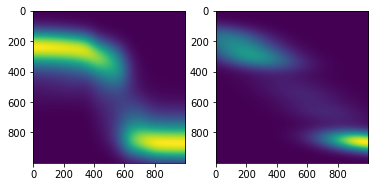

In [92]:
f,ax = plt.subplots(1,2)
p = np.exp(logscore)
p=p/p.sum(axis=0)
ax[0].imshow(p)
ax[1].imshow(rare_post.T)

Text(0.5, 1.0, 'Marginal Histograms vs Ideal Freq. Prior')

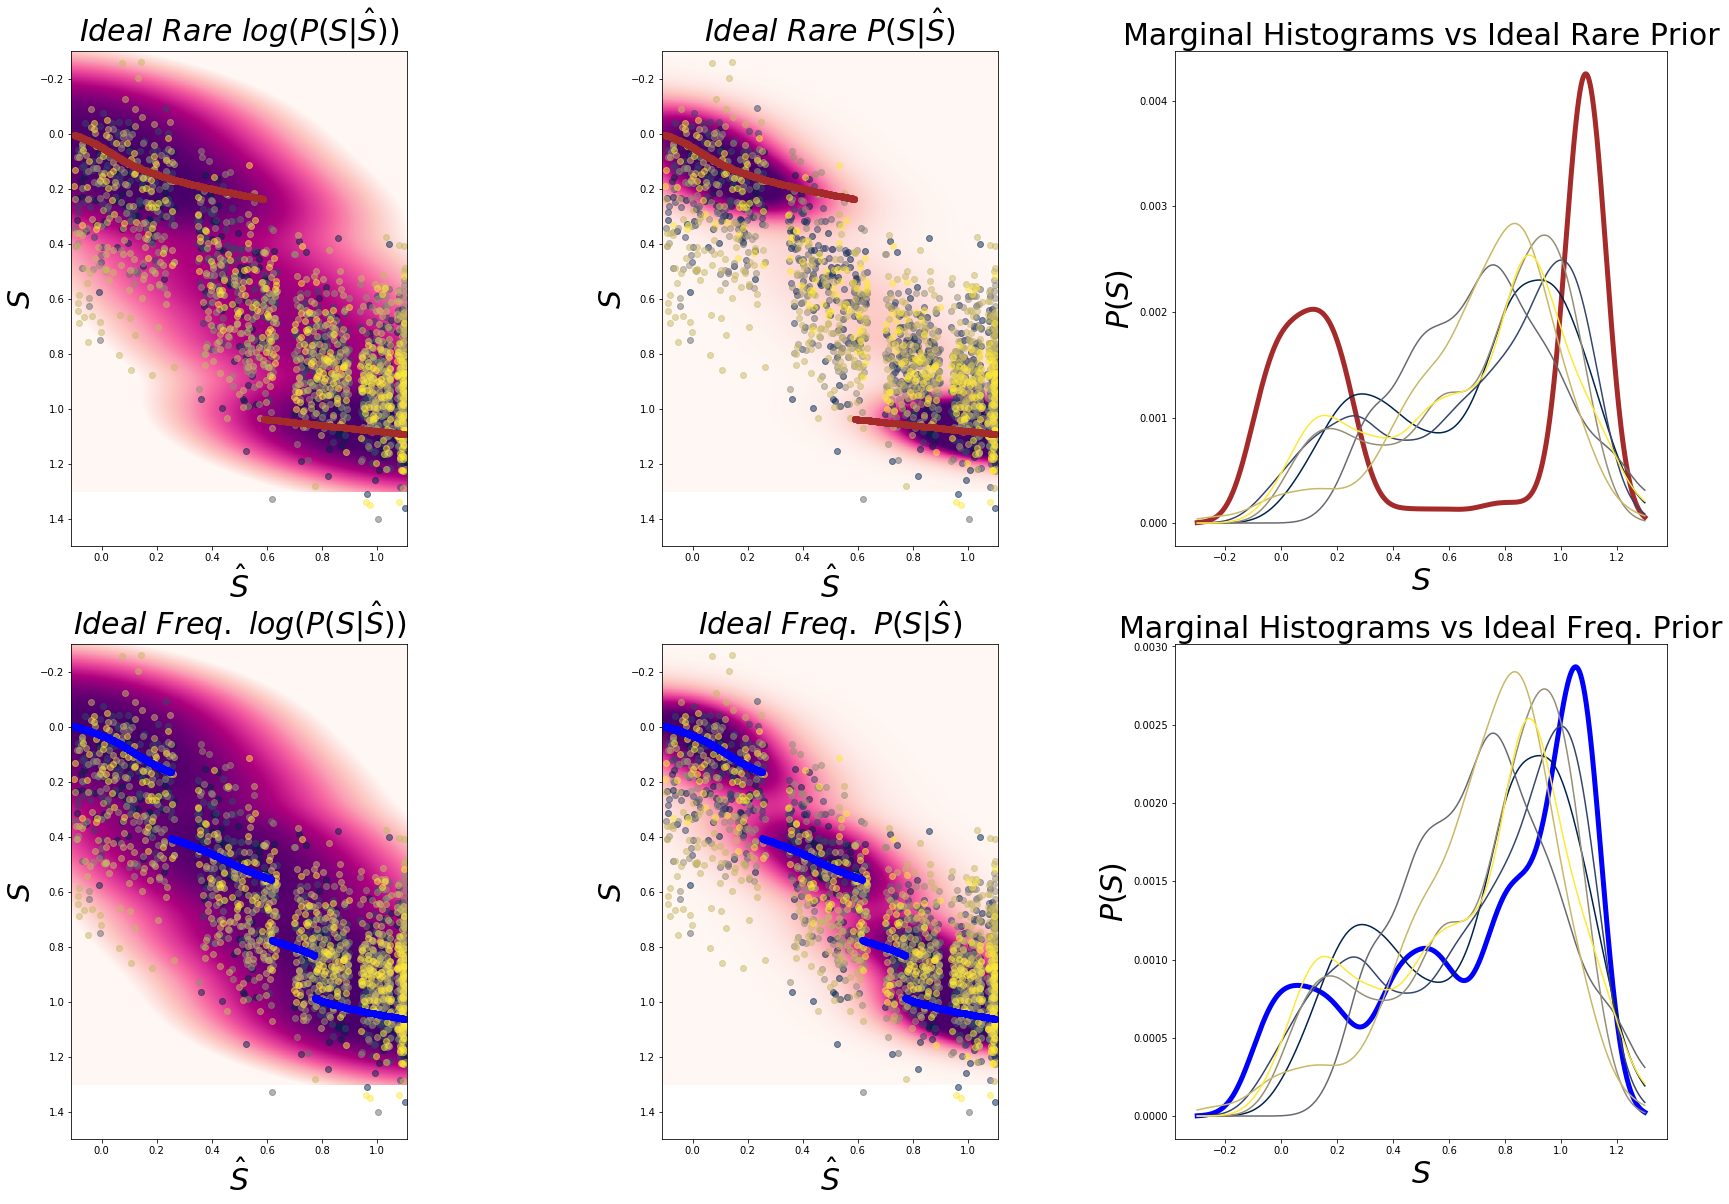

In [70]:
f,ax = plt.subplots(2,3,figsize=[30,20])

rare_logpost = np.log(rare_post.T)
ax[0,0].imshow(rare_logpost,vmin=np.percentile(rare_logpost,20),vmax=np.percentile(rare_logpost,95),extent =[-.11,1.11,1.3,-.3],cmap='RdPu')
ax[0,1].imshow(rare_post.T,vmin=np.percentile(rare_post,20),vmax=np.percentile(rare_post,95),extent =[-.11,1.11,1.3,-.3],cmap='RdPu')
ax[0,2].plot(x.ravel(),rare_prior.ravel(),color='brown',linewidth=5)

freq_logpost = np.log(freq_post.T)
ax[1,0].imshow(freq_logpost,vmin=np.percentile(freq_logpost,20),vmax=np.percentile(freq_logpost,95),extent =[-.11,1.11,1.3,-.3],cmap='RdPu')
ax[1,1].imshow(freq_post.T,vmin=np.percentile(freq_post,20),vmax=np.percentile(freq_post,95),extent =[-.11,1.11,1.3,-.3],cmap='RdPu')
ax[1,2].plot(x.ravel(),freq_prior.ravel(),color='blue',linewidth=5)

for i, (mouse, res) in enumerate(freq_sfreg.items()):
    _wallmorph = np.concatenate(res['wallmorph'])
    _yhat = np.concatenate(res['yhat'])
    ax[0,0].scatter(_wallmorph,_yhat,color=plt.cm.cividis(np.float(i/len(rare_mice))),alpha=.5)
    ax[0,1].scatter(_wallmorph,_yhat,color=plt.cm.cividis(np.float(i/len(rare_mice))),alpha=.5)
    ax[1,0].scatter(_wallmorph,_yhat,color=plt.cm.cividis(np.float(i/len(rare_mice))),alpha=.5)
    ax[1,1].scatter(_wallmorph,_yhat,color=plt.cm.cividis(np.float(i/len(rare_mice))),alpha=.5)
    
    sfsmooth = np.mean(gaussian(_yhat[:,np.newaxis],.1,x),axis=0)
    ax[0,2].plot(x.ravel(),sfsmooth/sfsmooth.sum(),color=plt.cm.cividis(np.float(i/len(rare_mice))))
    ax[1,2].plot(x.ravel(),sfsmooth/sfsmooth.sum(),color=plt.cm.cividis(np.float(i/len(rare_mice))))

xx = np.linspace(-.1,1.1,num=1000)
rare_ytarget = x[0,np.argmax(rare_prior*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax[0,0].scatter(xx,rare_ytarget,color='brown')
ax[0,1].scatter(xx,rare_ytarget,color='brown')

freq_ytarget = x[0,np.argmax(freq_prior*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax[1,0].scatter(xx,freq_ytarget,color='blue')
ax[1,1].scatter(xx,freq_ytarget,color='blue')


ax[0,0].set_xlabel("$\hat{S}$",fontsize=30)
ax[0,0].set_ylabel("$S$",fontsize=30)
ax[0,0].set_title("$Ideal \  Rare \ log(P(S|\hat{S}))$",fontsize=30)

ax[0,1].set_xlabel("$\hat{S}$",fontsize=30)
ax[0,1].set_ylabel("$S$",fontsize=30)
ax[0,1].set_title("$Ideal \  Rare \ P(S|\hat{S})$",fontsize=30)

ax[0,2].set_xlabel("$S$",fontsize=30)
ax[0,2].set_ylabel("$P(S)$",fontsize=30)
ax[0,2].set_title("Marginal Histograms vs Ideal Rare Prior",fontsize=30)

ax[1,0].set_xlabel("$\hat{S}$",fontsize=30)
ax[1,0].set_ylabel("$S$",fontsize=30)
ax[1,0].set_title("$Ideal \ Freq. \ log(P(S|\hat{S}))$",fontsize=30)

ax[1,1].set_xlabel("$\hat{S}$",fontsize=30)
ax[1,1].set_ylabel("$S$",fontsize=30)
ax[1,1].set_title("$Ideal \ Freq. \ P(S|\hat{S})$",fontsize=30)

ax[1,2].set_xlabel("$S$",fontsize=30)
ax[1,2].set_ylabel("$P(S)$",fontsize=30)
ax[1,2].set_title("Marginal Histograms vs Ideal Freq. Prior",fontsize=30)

# f.savefig("D:\\Morph_Results\\freq_sf_reg_density.png",format="png")

In [87]:
mouse = '4139265.5'
df_mouse_b = df[df["MouseName"]==mouse]
df_mouse_i = df_mouse_b[df_mouse_b['Imaging']==1]
df_mouse_i

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanmat,s2pfolder
1410,4139265.5,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,D:\VR_Data\TwoTower\4139265.5\10_02_2019\TwoTo...,None,None
1412,4139265.5,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,D:\VR_Data\TwoTower\4139265.5\10_02_2019\TwoTo...,None,None
1439,4139265.5,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,D:\VR_Data\TwoTower\4139265.5\12_02_2019\TwoTo...,None,None
1462,4139265.5,15_02_2019,2,TwoTower_foraging,86,1,CA1,2019-02-15,D:\VR_Data\TwoTower\4139265.5\15_02_2019\TwoTo...,None,None
1481,4139265.5,17_02_2019,2,TwoTower_foraging,80,1,CA1,2019-02-17,D:\VR_Data\TwoTower\4139265.5\17_02_2019\TwoTo...,None,None
1501,4139265.5,19_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-19,D:\VR_Data\TwoTower\4139265.5\19_02_2019\TwoTo...,None,None
1519,4139265.5,21_02_2019,2,TwoTower_foraging,105,1,CA1,2019-02-21,D:\VR_Data\TwoTower\4139265.5\21_02_2019\TwoTo...,None,None
1528,4139265.5,22_02_2019,2,TwoTower_foraging,98,1,CA1,2019-02-22,D:\VR_Data\TwoTower\4139265.5\22_02_2019\TwoTo...,None,None
1534,4139265.5,23_02_2019,2,TwoTower_foraging,96,1,CA1,2019-02-23,D:\VR_Data\TwoTower\4139265.5\23_02_2019\TwoTo...,None,None
1539,4139265.5,24_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-24,D:\VR_Data\TwoTower\4139265.5\24_02_2019\TwoTo...,None,None


In [88]:
first_ind = 5

morph_data = single_mouse_data(mouse,df_mouse_b)

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6
7
8


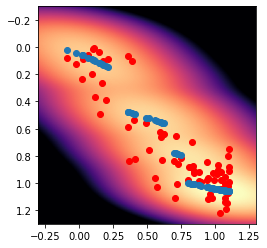

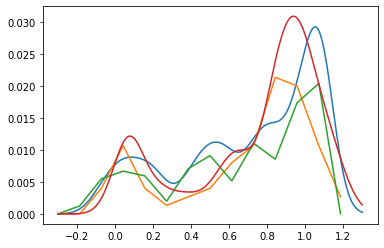

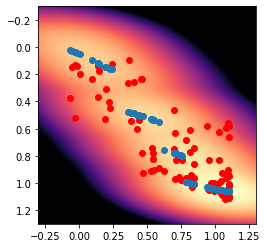

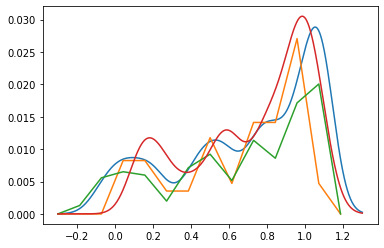

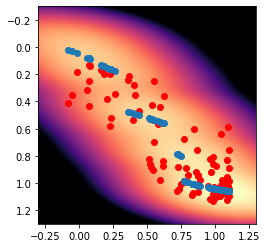

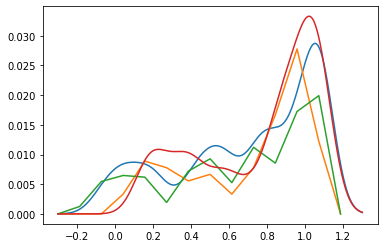

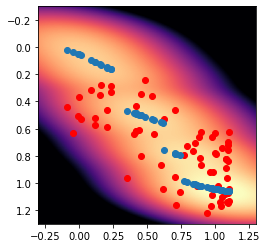

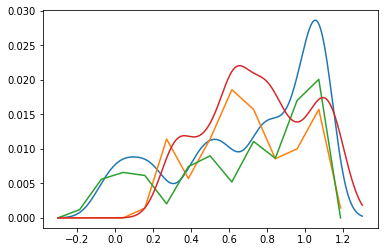

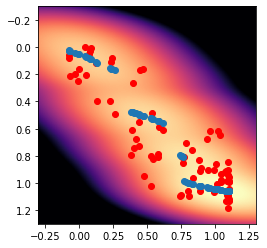

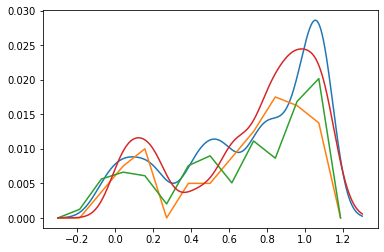

In [37]:
sigma_prior, sigma_likelihood = .1, .3
x,mus = np.linspace(-.3,1.3,num=1000)[np.newaxis,:],np.linspace(-.3,1.3,num=1000)[:,np.newaxis]
WALLMORPH = []
YHAT = []
for ind in range(first_ind,df_mouse_i.shape[0]):
    sess = df_mouse_i.iloc[ind]
    
    print(ind)
    # calculate cumulative prior up to current session
    date_folder,sessn = None,-np.inf
    em_all = None
    b_ind = 0
    while date_folder!=sess['DateFolder'] or sessn<sess["SessionNumber"]:
        b_sess = df_mouse_b.iloc[b_ind]
        date_folder = b_sess['DateFolder']
        sessn = b_sess['SessionNumber']
        if em_all is None:
            em_all = morph_data[date_folder+str(sessn)]
        else:
            em_all = np.concatenate((em_all,morph_data[date_folder+str(sessn)]),axis=0)
        b_ind+=1
    
        
    
    prior = np.mean(gaussian(em_all[:,:1],sigma_prior,x),axis=0,keepdims=True)
    prior_spl = lambda x: np.mean(gaussian(em_all[:,:1],sigma_prior,x),axis=0,keepdims=True)
    
    

    # load data
    with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
        data = pickle.load(f)
    VRDat,S = data['VRDat'],data['S']
    S[np.isnan(S)]=0
    S = S/np.percentile(S,95,axis=0)
    trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
    S_trial_mat[np.isnan(S_trial_mat)]=0
    
    
    # similarity fraction
    sf = u.similarity_fraction(S_trial_mat,trial_info)
    
    
    morphmat = trial_info_to_morph(data['trial_info'])
    wallMorph = morphmat[:,0]
    WALLMORPH.append(wallMorph)

     # need to add cross val
    ytarget = x[0,np.argmax(prior_spl(x)*gaussian(wallMorph[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
    yhat = np.zeros(ytarget.shape)
    for trial in range(yhat.shape[0]):
        train = np.ones(yhat.shape)>0
        train[trial]= False
        
        linmodel = hreg().fit(sf[train,np.newaxis],ytarget[train].ravel())
        yhat[trial]=linmodel.predict(sf[trial].reshape(-1,1))
    
    YHAT.append(yhat)
#     linmodel = hreg().fit(sf[:,np.newaxis],ytarget[:,np.newaxis])
    f,ax = plt.subplots()
    
    logpost = np.log(prior*gaussian(mus,sigma_likelihood,x))
    ax.imshow(logpost.T,vmin=np.percentile(logpost,20),vmax=np.percentile(logpost,99),extent =[-.3,1.3,1.3,-.3],cmap='magma')
#     ax.scatter(wallMorph,linmodel.predict(sf[:,np.newaxis]),color='red')
    ax.scatter(wallMorph,yhat,color='red')
    ax.scatter(wallMorph,ytarget)
    
    
    f,ax = plt.subplots()
    ax.plot(x.ravel(),prior.ravel()/prior.sum()*10)
    hist,edges = np.histogram(yhat,bins=np.linspace(-.3,1.3,num=15))
    ax.plot(edges[0:-1],hist/hist.sum()/10)
    hist2,edges = np.histogram(em_all[:,:1],bins=edges)
    ax.plot(edges[0:-1],hist2/hist2.sum()/10)
    sfsmooth = np.mean(gaussian(yhat[:,np.newaxis],.1,x),axis=0)
    ax.plot(x.ravel(),sfsmooth/sfsmooth.sum()*10)

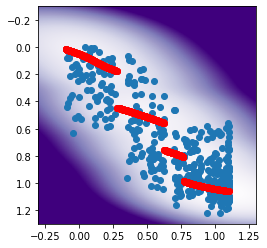

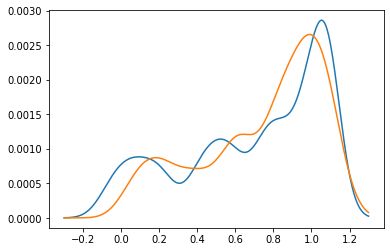

In [43]:
f,ax = plt.subplots()
_yhat = np.concatenate(YHAT)
_wallmorph = np.concatenate(WALLMORPH)
ax.imshow(logpost.T,vmin=np.percentile(logpost,20),vmax=np.percentile(logpost,99),extent =[-.3,1.3,1.3,-.3],cmap='Purples_r')
# ax.imshow(np.exp(logpost.T),extent =[-.3,1.3,1.3,-.3],cmap='Purples_r')
ax.scatter(_wallmorph,_yhat)
xx = np.linspace(-.1,1.1,num=1000)
ytarget = x[0,np.argmax(prior_spl(x)*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax.scatter(xx,ytarget,color='red')

 
f,ax = plt.subplots()
ax.plot(x.ravel(),prior.ravel()/prior.sum())
sfsmooth = np.mean(gaussian(_yhat[:,np.newaxis],.1,x),axis=0)
ax.plot(x.ravel(),sfsmooth/sfsmooth.sum())

### Confirming recapitualation of Unity planes

In [159]:
# ensure texture looks the same as unity

intens = lambda xs,ys, f, theta: np.cos(2.*np.pi*f*(xs*(np.cos(theta + np.pi/4.)+np.sin(theta+np.pi/4.)) + ys*(np.cos(theta+np.pi/4.)-np.sin(theta+np.pi/4))))


In [160]:
f1,f2 = 2.5,3.5
theta1,theta2 = 60.,10.
morph = 1.
f = morph*f1 + (1-morph)*f2
print(f)
theta = (morph*theta1  + (1-morph)*theta2) * np.pi / 180
print(theta)
texture = np.zeros([120,1500])
for y in range(texture.shape[1]):
    for x in range(texture.shape[0]):
        xs = x/texture.shape[1]*1
        ys = y/texture.shape[0]*1
        texture[x,y]=intens(xs,ys,f,theta)#+ intens(ys,xs,f,theta)
print(xs,ys)

2.5
1.0471975511965976
0.07933333333333334 12.491666666666667


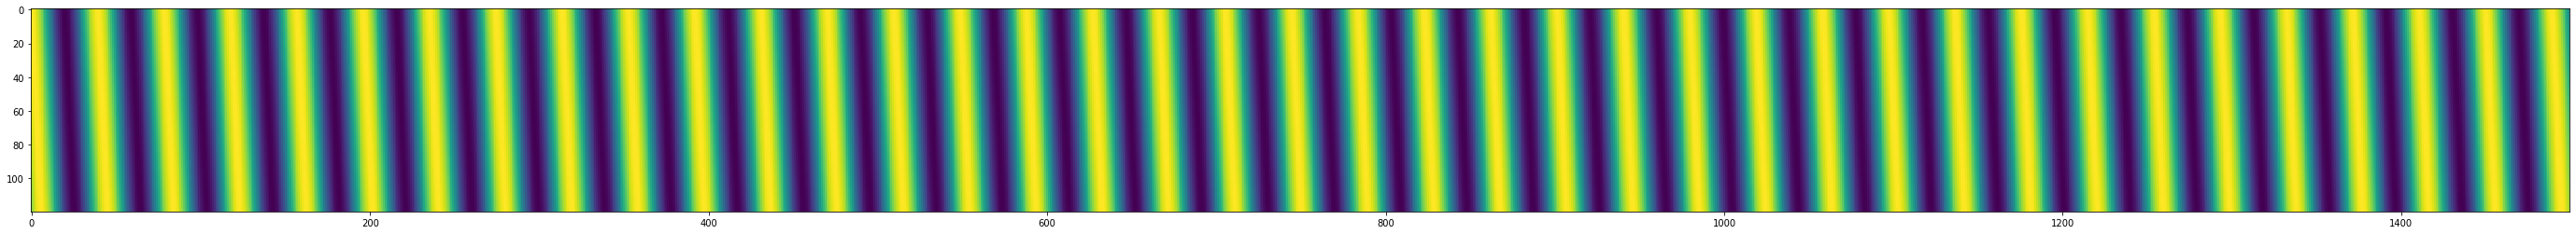

In [161]:
f,ax = plt.subplots(1,1,figsize=[50,4],sharex=True)
ax.imshow(texture)


In [197]:
xfreq = lambda f,theta: f*1500/120*(np.cos(theta + np.pi/4.)-np.sin(theta+np.pi/4.)) 
yfreq = lambda f,theta: f*1500/120*(np.cos(theta + np.pi/4.)+np.sin(theta+np.pi/4.)) 

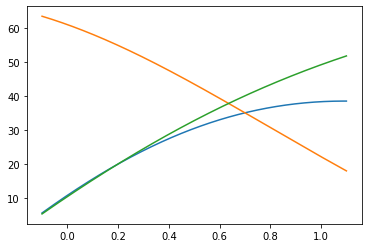

In [199]:
morphs = np.linspace(-.1,1.1,num=1000)
# xcoeff = np.zeros(morphs.shape)
f,theta = morphs*f1 + (1-morphs)*f2, (morphs*theta1  + (1-morphs)*theta2) * np.pi / 180
xcoeff = xfreq(f,theta)
ycoeff = yfreq(f,theta)
fig,ax = plt.subplots()
ax.plot(morphs,np.abs(xcoeff))
ax.plot(morphs,np.abs(ycoeff))
# ax.plot(morphs,np.abs(ycoeff))
# ang = np.abs(np.arctan(xcoeff/ycoeff)*180/np.pi)
# ax.plot(morphs,ang)

ax.plot(morphs,.5*(ang+np.abs(xcoeff)))
# ax.plot(morphs,5*np.log(np.abs(xcoeff)))

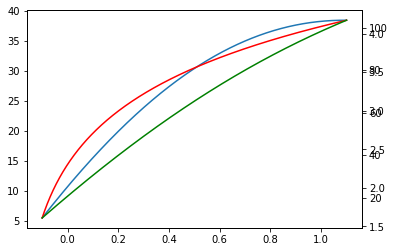

In [207]:
f,ax = plt.subplots()
ax.plot(morphs,np.abs(xcoeff))
ax2 = ax.twinx()
ax2.plot(morphs,np.log(ang),color='red')
ax3= ax.twinx()
ax3.plot(morphs,np.abs(xcoeff)+ang,color='green')